In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, roc_auc_score)

In [26]:
df = pd.read_csv('spQ1.csv')
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (4424, 12)


,Marital status,Daytime/evening attendance,Nationality,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,International,Age at enrollment,Target_status
0,1,1,1,1,0,0,1,1,0,0,20,1
1,1,1,1,1,0,0,0,1,0,0,19,2
2,1,1,1,1,0,0,0,1,0,0,19,1
3,1,1,1,1,0,0,1,0,0,0,20,2
4,2,0,1,0,0,0,1,0,0,0,45,2


In [27]:
df["Dropout"] = df["Target_status"].apply(lambda x: 1 if x == 1 else 0)

df_plot = df.copy()
df_plot["Dropout_label"] = df_plot["Dropout"].map({0: "No Dropout", 1: "Dropout"})

if "Gender" in df_plot.columns:
    df_plot["Gender"] = df_plot["Gender"].map({0: "Female", 1: "Male"})
if "Scholarship holder" in df_plot.columns:
    df_plot["Scholarship holder"] = df_plot["Scholarship holder"].map({0: "No", 1: "Yes"})
if "International" in df_plot.columns:
    df_plot["International"] = df_plot["International"].map({0: "Local", 1: "International"})
if "Educational special needs" in df_plot.columns:
    df_plot["Educational special needs"] = df_plot["Educational special needs"].map({0: "No", 1: "Yes"})
if "Debtor" in df_plot.columns:
    df_plot["Debtor"] = df_plot["Debtor"].map({0: "No", 1: "Yes"})
if "Tuition fees up to date" in df_plot.columns:
    df_plot["Tuition fees up to date"] = df_plot["Tuition fees up to date"].map({0: "No", 1: "Yes"})


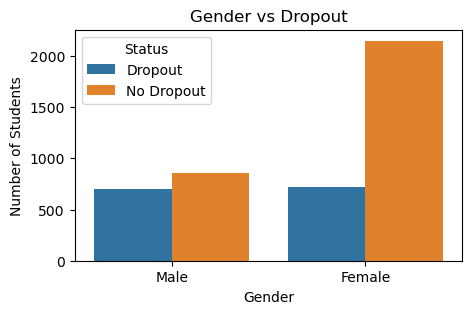

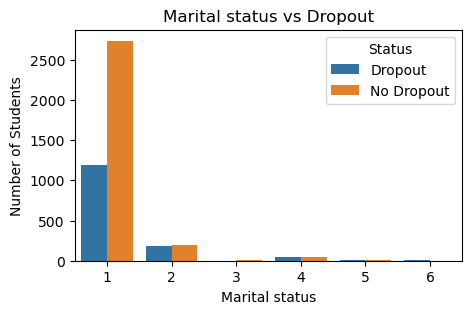

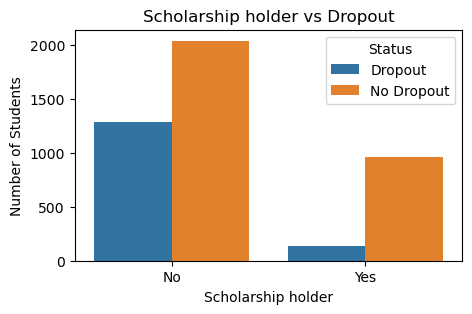

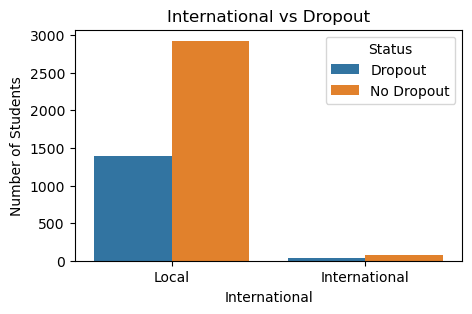

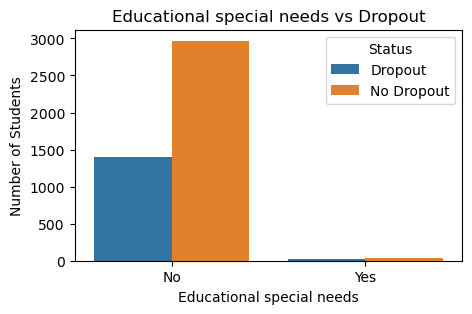

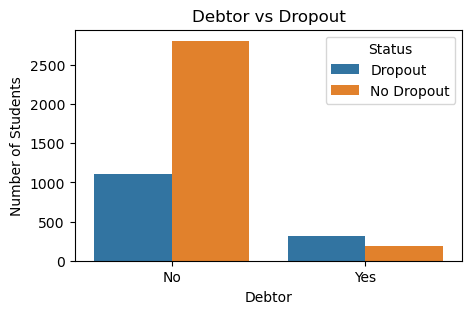

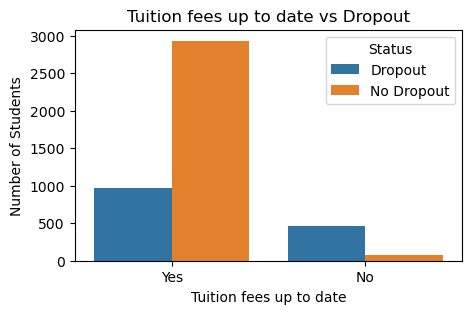

In [28]:
features_for_eda = ["Gender", "Marital status", "Scholarship holder", "International", "Educational special needs", "Debtor", "Tuition fees up to date"]

for col in features_for_eda:
    if col in df_plot.columns:
        plt.figure(figsize = (5,3))
        sns.countplot(data = df_plot, x = col, hue = "Dropout_label")
        plt.title(f"{col} vs Dropout")
        plt.xlabel(col)
        plt.ylabel("Number of Students")
        plt.legend(title = "Status")
        plt.show()

In [29]:
features = ["Gender", "Age at enrollment", "Marital status", "International", "Educational special needs", "Scholarship holder", "Debtor"]
X = df[features].copy()
y = pd.to_numeric(df["Target_status"], errors = "coerce").fillna(0).astype(int)

print("Features:", features)
print("Target distribution:\n", y.value_counts())

Features: ['Gender', 'Age at enrollment', 'Marital status', 'International', 'Educational special needs', 'Scholarship holder', 'Debtor']
Target distribution:
 Target_status
2    2209
1    1421
3     794
Name: count, dtype: int64


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)

numeric_cols = X.select_dtypes(include = [np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

In [31]:
num_pipe = Pipeline([('imputer', SimpleImputer(strategy = 'median'))])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')), ('ohe', OneHotEncoder(handle_unknown = 'ignore'))])

pre = ColumnTransformer([('num', num_pipe, numeric_cols), ('cat', cat_pipe, categorical_cols)], sparse_threshold = 0)

In [32]:
log = Pipeline([('pre', pre), ('clf', LogisticRegression(max_iter = 1000, class_weight = 'balanced'))])

rf = Pipeline([('pre', pre), ('clf', RandomForestClassifier(n_estimators = 200, random_state = 42, class_weight = 'balanced'))])

log.fit(X_train, y_train)
rf.fit(X_train, y_train)

,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [34]:
y_pred_log = log.predict(X_test)
print("\n=== Logistic Regression Results ===")
print(classification_report(y_test, y_pred_log))

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)
print("\n=== Random Forest Results ===")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC (ovr):", roc_auc_score(y_test, y_proba_rf, multi_class = 'ovr'))
print("ROC AUC (ovo):", roc_auc_score(y_test, y_proba_rf, multi_class = 'ovo'))


=== Logistic Regression Results ===
              precision    recall  f1-score   support

           1       0.59      0.56      0.57       284
           2       0.75      0.42      0.54       442
           3       0.23      0.52      0.32       159

    accuracy                           0.48       885
   macro avg       0.52      0.50      0.48       885
weighted avg       0.60      0.48      0.51       885


=== Random Forest Results ===
              precision    recall  f1-score   support

           1       0.53      0.48      0.50       284
           2       0.68      0.58      0.63       442
           3       0.20      0.31      0.24       159

    accuracy                           0.50       885
   macro avg       0.47      0.46      0.46       885
weighted avg       0.55      0.50      0.52       885

ROC AUC (ovr): 0.6584371749315986
ROC AUC (ovo): 0.643772783427373


In [35]:
log_reg_model = log.named_steps['clf']
feature_names = numeric_cols
if categorical_cols:
    ohe = log.named_steps['pre'].named_transformers_['cat'].named_steps['ohe']
    cat_names = ohe.get_feature_names_out(categorical_cols).tolist()
    feature_names = numeric_cols + cat_names

coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": log_reg_model.coef_[0]}).sort_values(by = "Coefficient", ascending = False)

print("\n=== Logistic Regression Coefficients ===")
display(coef_df)


=== Logistic Regression Coefficients ===


,Feature,Coefficient
6,Debtor,0.790914
0,Gender,0.372402
4,Educational special needs,0.209951
1,Age at enrollment,0.041488
2,Marital status,-0.070592
3,International,-0.395404
5,Scholarship holder,-0.563497



=== Top Feature Importances (Random Forest) ===
Age at enrollment            0.579881
Scholarship holder           0.146233
Debtor                       0.088040
Gender                       0.079575
Marital status               0.068236
International                0.023293
Educational special needs    0.014742
dtype: float64


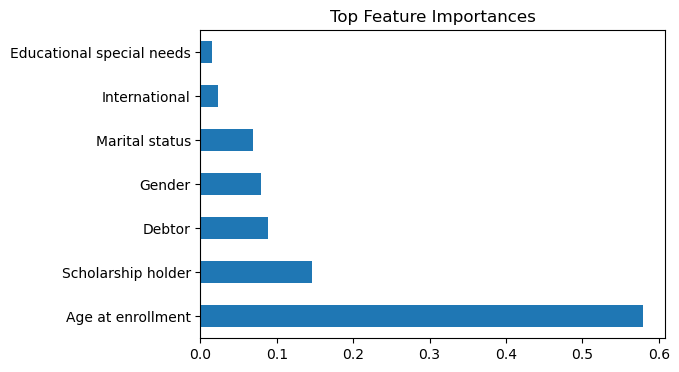

In [37]:
importances = rf.named_steps['clf'].feature_importances_
feat_imp = pd.Series(importances, index = feature_names).sort_values(ascending = False)

print("\n=== Top Feature Importances (Random Forest) ===")
print(feat_imp.head(10))

feat_imp.head(10).plot(kind = 'barh', figsize = (6,4), title = "Top Feature Importances")
plt.show()